# Lean, Mean, Stats Machine: Final Project

The following code details:
 * Data collection 
 * Exploration 
 * Model construction
 * Analysis of Text Sentiment 

Related to news articles across the last four years, since March 11, 2020, which is when COVID was declared an epidemic. 

Our focus will be on the difference between articles from two news outlets on opposing sides of the political spectrum, Fox and Vox. We pair text sentiment data with COVID statistics -- gathered from an external API -- to compare and contrast how different variables affect the sentiment between these two outlets.

### Importing Necessary Packages

In [1]:
# Webscraping Librarie
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import time
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

# Multi-threading for faster scraping
from multiprocessing import Pool
import concurrent.futures

# Data Manipulation Libraries
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt

# Text Processing Libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
import re
nltk.download('vader_lexicon')

# Other Libraries
import json
from urllib.request import urlopen

# Stats Libraries
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
from sklearn.model_selection import TimeSeriesSplit

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Webscraping - FOX News

First we define some basic variables. We are scraping FOX news content directly from an archive website, and use a convenient link format that includes a query with the year, and the page number of the resulting query. Each header that appears in each of these links is actually a set of articles, and not just one article.

Through manual inspection, we also define how many pages of news content each year has in this archive website. 

In [17]:
# Define webscraping relevant variables
headers = { 
    'User-Agent': 'Mozilla/5.0 (Windows NT x.y; Win64; x64; rv:10.0) Gecko/20100101 Firefox/10.0'
}

FOX_BASE = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A\"{0}\"&page='

foxArchive2020 = FOX_BASE.format('2020')
foxArchive2021 = FOX_BASE.format('2021')
foxArchive2022 = FOX_BASE.format('2022')
foxArchive2023 = FOX_BASE.format('2023')

totPg2020 = 111
totPg2021 = 107
totPg2022 = 111
totPg2023 = 54

Given the base format of a url, for each year in our case, this function returns the entry point, i.e another web page, to access raw text content of FOX news articles. 

In [23]:
def getArticleURLs(base_url, num_pages):
    '''
    Webscraper for the URLS of all articles on a given page
    '''
    articleURLs = []
    archiveBase = 'https://archive.org'

    try:
        for page in tqdm(range(num_pages)):
            url  = base_url + str(page+1)

            request  = requests.get(url, headers = headers)
            soup     = BeautifulSoup(request.content,'lxml')

            articleEntry = soup.find_all('div',{'class':'item-ttl'})

            articleAnchors = [archiveBase + 
                              articleEntry[i].find('a').get('href') 
                              for i in range(len(articleEntry))]
            
            articleURLs.extend(articleAnchors)
    except:
        print('Idk, something broke')
        
    return articleURLs

In [ ]:
articleURLs2020 = getArticleURLs(foxArchive2020, totPg2020)
articleURLs2021 = getArticleURLs(foxArchive2021, totPg2021)
articleURLs2022 = getArticleURLs(foxArchive2022, totPg2022)
articleURLs2023 = getArticleURLs(foxArchive2023, totPg2023)

Getting article dates so that now each piece of text can be paired with the date it was published. 

In [ ]:
def get_article_dates(article_urls):
    '''
    Gathers the dates of each article
    '''
    dates_unsplit = [''.join(article_urls[i].split('/')).split('_')[1] for i in range(len(article_urls))]
    split_dates = [(date[:4],date[4:6],date[-2:]) for date in dates_unsplit]
    
    return dict(zip(article_urls,split_dates))

Now that we have access to the intermediary web pages, we scrape those and return a dictionary where the keys are the article texts themselves, and the values are the date they were published. 

There are approximately 8000 of these intermediary pages with about 60 pieces of text each. This is simply too much data for our purposes, we instead select 2000 random sets of articles to parse. Even when taking this into account, we have about 400,000 pieces of text in the final table. 

In [ ]:
def get_article_contents(article_set_urls, num_rand_articles):
    '''
    Parse through the article sets and return a dictionary of snippets and their associated dates
    '''
    
    article_date_dict = get_article_dates(article_set_urls)
    article_date_pairings = {}
    
    random_indices = np.random.randint(low=0,high=len(article_set_urls),size=num_rand_articles)
    rand_article_sets = np.array(article_set_urls)[random_indices]
        
    for article_set_url in tqdm(rand_article_sets):
    
        associated_date = article_date_dict[article_set_url]
        year, month,day = int(associated_date[0]),int(associated_date[1]), int(associated_date[2])
        
        # Looking at only data past March 11,2020
        if (month < 3 and day < 11) and year == 2020:
            continue
        
        cur_article_req = requests.get(article_set_url,headers=headers)
        cur_article_soup = BeautifulSoup(cur_article_req.content,'lxml')
        
        article_snippets = cur_article_soup.find_all('div',{'class':'snipin nosel'})
        text_snippets = [snippet.text.replace('\n','').replace('\t','') for snippet in article_snippets]
        
        for snippet in text_snippets:
            article_date_pairings[snippet] = associated_date
    
    return article_date_pairings

Ran this code for each year. 

In [ ]:
num_ran_articles = 2000

article_date_pairings_2023 = get_article_contents(articleURLs2023, num_ran_articles) 

In [ ]:
with open('Serialized Datasets/2023_articles.pkl','wb') as pickle_file:
    pickle.dump(article_date_pairings_2023,pickle_file)

### Webscraping - VOX
---
"Left" leaning news outlets were chosen based off of political lean ratings determined by [AllSides](https://www.allsides.com/about) which is a media solutions company which establishes a third-party review of the political affilation and perspectives which various media outlets display. They also provide community-based tools which help establish an agreement and validity scale of their results by permitting users to vote on whether or not they agree or disagree with the lean they deem on a website.

- [Vox Media](https://www.vox.com/) which declared bankruptcy recently lol.
    - AllSides gives it a score of -4 indicating that it is a solid Left lean.

In [ ]:
def get_vox_news(from_:str, to_:str):
    '''
    Performs webscraping of the archieve 

    Parameters
    ----------
    from_ (str): Start date of the search in the format YYYY-MM
    to_ (str):   End date of the search in the format YYYY-MM

    Returns
    -------
    dict: Dictionary containing news headlines, links, dates, and media source
    '''
    # Configure Selenium Webdriver
    chromeOptions = Options()
    chromeOptions.add_argument("--headless=new")
    driver = webdriver.Chrome(options=chromeOptions)

    # Utilize beautiful soup to scrape the Vox archive
    main_url = 'https://www.vox.com/archives'

    # Relevant fields for search
    optimized_feature = 'data-chorus-optimize-field'
    analytic_feature = 'data-analytics-link'

    # Generate list of relevant dates to search from the Vox archive
    dates = pd.date_range(from_, to_, freq='MS').strftime("%Y/%#m").tolist()

    # Search through the archive within dates
    all_headlines = {}
    with tqdm(total=len(dates)) as pbar:
        for date in dates:
            dated_url = f'{main_url}/{date}'
            driver.get(dated_url)

            # Continue to press the "Load More" button while it is clickable
            while True:
                try:
                    # Wait for "Load More" button to be clickable
                    load_more = WebDriverWait(driver, 10, 8).until(
                        EC.element_to_be_clickable((By.CLASS_NAME, 'c-archives-load-more__button')
                    )) # Little reminder that CLASS_NAME can only be singular, no spaces
                    load_more.click()
                except:
                    break
            
            # Create a BeautifulSoup object
            soup = BeautifulSoup(driver.page_source, 'html.parser')

            # Find all the <a> tags
            headlines = soup.find_all('a', {optimized_feature: 'hed', analytic_feature: True})
            times     = soup.find_all('time', {'class': 'c-byline__item', 'data-ui': 'timestamp'})

            # Add headlines to dictionary as key and links and date as values
            for headline, time in zip(headlines, times):
                all_headlines[headline.text] = {
                    "link": headline['href'],
                    "date": time['datetime'][:10],
                    "source": "Vox"
                }
            
            # Update the progress bar
            pbar.update()
    driver.quit()
    return all_headlines

In [ ]:
vox_results = get_vox_news('2019-03', '2023-05')

In [ ]:
vox_df = pd.DataFrame.from_dict(vox_results, orient='index')
# Sort the data by date
vox_df.sort_values(by='date', inplace=True)

In [ ]:
def get_content(link: str) -> str:
    '''
    Gathers the content of the article from the link

    Parameters
    ----------
    link (str): Link to the article

    Returns
    -------
    str: Content of the article
    '''
    # Uses simple requests to get the content of the article
    totalTime = 0
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    content = soup.find_all('p')
    # Wait and retry if the content is empty
    while (len(content) == 0) and (totalTime < 300):
        time.sleep(30)
        totalTime += 30
        response = requests.get(link)
        soup = BeautifulSoup(response.content, 'html.parser')
        content = soup.find_all('p')
    # Remove the last 7 paragraphs which is not part of the article
    content = content[:-7]
    print(link)
    return '\n'.join([c.text for c in content])

In [ ]:
def process_links(links: list) -> list:
    '''
    Processes the links in parallel using multithreading

    Parameters
    ----------
    df (pd.DataFrame): Dataframe containing the links

    Returns
    -------
    list: List of article contents
    '''
    # Create a pool of workers to execute processes
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Execute the processes and return the results
        futures = [executor.submit(get_content, link) for link in links]

        # Wait for the processes to finish and return the results
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    return results

### Shared Preprocessing Script
---
Our pre-processing function for the raw text before we calculate a sentiment score for each piece.

In [6]:
pattern = re.compile(r'[^A-Za-z0-9 ]+')
stopword_set = set([word.lower() for word in stopwords.words('english')])
stemmer = SnowballStemmer('english')

def preprocess_article(article: str) -> str:
    '''
    Preprocess the article content by removing punctuation, numbers, and stopwords and tokenizing the words

    Parameters
    ----------
    article: str

    Returns
    -------
    None
    '''
    article = article.lower()
    article = article.translate(str.maketrans('', '', string.punctuation))
    article = pattern.sub('', article)
    
    content = nltk.word_tokenize(article)
    content = [stemmer.stem(word) for word in content if word.lower() not in stopword_set]

    final = ' '.join(content)
    return final

### Creating Tables from Scraped Data - FOX

In [3]:
article_date_pairings_2020 = pickle.load(open('Serialized Datasets/2020_articles.pkl','rb'))
article_date_pairings_2021 = pickle.load(open('Serialized Datasets/2021_articles.pkl','rb'))
article_date_pairings_2022 = pickle.load(open('Serialized Datasets/2022_articles.pkl','rb'))
article_date_pairings_2023 = pickle.load(open('Serialized Datasets/2023_articles.pkl','rb'))

Creating a more convenient format to parse the data across the four years

In [4]:

combined_dict = {
    '2020':article_date_pairings_2020,
    '2021':article_date_pairings_2021,
    '2022':article_date_pairings_2022,
    '2023':article_date_pairings_2023
}

all_articles = []
all_dates = []

for year in combined_dict.keys():
    current_articles,current_dates = combined_dict[year].keys(), combined_dict[year].values()
                                                                                    
    all_articles.extend(current_articles),all_dates.extend(current_dates)

Re-formatting dates so they are no longer ordered triples

In [5]:
years  = [all_dates[i][0] for i in range(len(all_dates))]
months = [all_dates[i][1] for i in range(len(all_dates))]
days   = [all_dates[i][2] for i in range(len(all_dates))]

reformatted_dates = [f'{years[i]}-{months[i]}-{days[i]}' for i in range(len(years))]

In [6]:
fox_df = pd.DataFrame({
    'Article Text':all_articles,
    'Year':years,
    'Month':months,
    'Day':days,
    'Full Date':reformatted_dates
})

,Article Text,Year,Month,Day,Full Date
0,at -- actually 49 days and 2 hours...,2020,09,15,2020-09-15
1,popular vote. >> his selection is ...,2020,09,15,2020-09-15
2,>> you know the old saying no news...,2020,09,15,2020-09-15
3,all age groups. the hospitalizatio...,2020,09,15,2020-09-15
4,and dr. fauci didn't elaborate on ...,2020,09,15,2020-09-15
...,...,...,...,...,...
398656,>> that's right. whoever has the c...,2023,05,26,2023-05-26
398657,it's really bad for you but i feel...,2023,05,26,2023-05-26
398658,>> i think we cracked the case. >>...,2023,05,26,2023-05-26
398659,scratcher eyeball. >> i'm going to...,2023,05,26,2023-05-26


In [9]:
tqdm.pandas(desc='Applying text-pre processing')

processed_text = ['Article Text'].progress_apply(preprocess_article)

Applying text-pre processing:   0%|          | 0/398661 [00:00<?, ?it/s]

In [10]:
fox_df['Article Text'] = processed_text

### Creating Tables from Scraped Data - Vox

In [ ]:
# Split the dataframe into 4 parts for each of the 4 years
vox_2020 = vox_df[vox_df['date'].str.contains('2020')]
vox_2021 = vox_df[vox_df['date'].str.contains('2021')]
vox_2022 = vox_df[vox_df['date'].str.contains('2022')]
vox_2023 = vox_df[vox_df['date'].str.contains('2023')]

# Put each of these dataframes into a list
vox_dfs = [vox_2020, vox_2021, vox_2022, vox_2023]

In [ ]:
# Process the links of each year with multithreading
# Add confirmations to prevent accidental execution
for i, df in enumerate(vox_dfs):
    print(f'Processing {i+1} of 4')
    confirmation = input('Continue? (y/n): ')
    if confirmation == 'y':
        # Get the content of the articles
        df['content'] = process_links(df['link'].tolist())
        # Export the dataframe to a csv file
        df.to_csv(f'vox_{i+1}.csv', encoding='utf-8-sig', chunksize=None)
    else:
        print('Skipping...')

Doing some data validation and cleaning.

In [2]:
# load in the full dataset
vox_df_full = pd.read_csv('vox_df_full_backup.csv', index_col=0)

In [3]:
# Parse out the date from each of the articles and then add them in by year, month, and day
vox_df_full['date'] = pd.to_datetime(vox_df_full['date'])

vox_df_full['Year'] = vox_df_full['date'].apply(lambda x: x.year)
vox_df_full['Month'] = vox_df_full['date'].apply(lambda x: x.month)
vox_df_full['Day'] = vox_df_full['date'].apply(lambda x: x.day)

In [4]:
# Add the index as a new column called headline
vox_df_full['headline'] = vox_df_full.index

# Reindex the dataframe to just use numbers
vox_df_full.reset_index(drop=True, inplace=True)

# Drop the link column
vox_df_full.drop('link', axis=1, inplace=True)

# Reorder the columns to headline, source, content, date, year, month, day
vox_df_full = vox_df_full[['headline', 'source', 'content', 'year', 'month', 'day', 'date']]

# Rename the columns to match the other dataframes
vox_df_full.rename(columns={'content':'Article Text'}, inplace=True)

# Drop the rows that have no content
vox_df_full.dropna(inplace=True)

In [7]:
# Run the preprocessing on the article content
tqdm.pandas(desc='Applying text-pre processing')

processed_text = vox_df_full['Article Text'].progress_apply(preprocess_article)

Applying text-pre processing:   0%|          | 0/20135 [00:00<?, ?it/s]

In [8]:
# Apply the processed text to the dataframe
vox_df_full['Article Text'] = processed_text

# Calculating Sentiment

To calculate sentimen of a piece of text we will use the VADER Sentiment Analyzer, which is convenient for regression problems, as it outputs both the sentiment and its associated strength in a certain direction. 

In [24]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    '''
    Simple function to analyze the sentiment of a piece of text
    '''
    sentiment_scores = sia.polarity_scores(text)
    sentiment        = sentiment_scores['compound']
    
    return sentiment

### Sentiment Analysis - Fox

In [2]:
# Read in the dataframe for Fox for quick validation
fox_df = pd.read_csv('full_table.csv', index_col=0)

In [ ]:
# Apply the Sentiment
tqdm.pandas(desc='Calculating Polarity Scores')
polarity_scores = fox_df['Article Text'].progress_apply(analyze_sentiment)

# Add the polarity scores to the dataframe
fox_df['Polarity Score'] = polarity_scores

In [ ]:
# Export to a csv file
fox_df.to_csv('full_table.csv', encoding='utf-8-sig', chunksize=None)

### Sentiment Analysis - Vox

In [26]:
# Apply the sentiment analysis to the vox dataframe
tqdm.pandas(desc='Calculating Polarity Scores')
polarity_scores = vox_df_full['Article Text'].progress_apply(analyze_sentiment)

Calculating Polarity Scores:   0%|          | 0/20135 [00:00<?, ?it/s]

In [27]:
vox_df_full['Polarity Score'] = polarity_scores

In [29]:
# Save to a csv file
vox_df_full.to_csv('vox_df_complete.csv', encoding='utf-8-sig', chunksize=None)

### Getting COVID statistics to merge with Sentiment Data
---
The following portion of our code will overview how we collected the COVID data and merged  it with the tables about sentiment.

In [44]:
# Process through the COVID Statistics from API
apiKEY      = '3683057711b142c8a7508f588006e6be'
request     = 'https://api.covidactnow.org/v2/country/US.timeseries.json?apiKey=' + apiKEY
response    = urlopen(request).read()
covid_stats = json.loads(response.decode('utf-8','strict'))

In [45]:
# Parse through the timeseries data to create a dictionary of dates and relevant data
timeSeries = covid_stats['metricsTimeseries']

keys  = timeSeries[0].keys()
data  = [[] for _ in keys]

timeSeriesDict = dict(zip(keys, data))

# Combine the actual values within the data to the dictionary
for entry in timeSeries:
    for key in entry:
        try:
            timeSeriesDict[key].append(entry[key])

        # Continue if ragged entries encountered (e.g., Fall 2022 Booster Recieved Rate)
        except KeyError:
            continue

In [46]:
covid_df = pd.DataFrame(timeSeriesDict)
covid_df

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,contactTracerCapacityRatio,infectionRate,infectionRateCI90,icuCapacityRatio,bedsWithCovidPatientsRatio,weeklyCovidAdmissionsPer100k,date
0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-09
1,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-10
2,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-11
3,NaN,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
4,NaN,0.1,0.4,NaN,1.83,0.83,NaN,NaN,NaN,2020-03-13
...,...,...,...,...,...,...,...,...,...,...
1186,NaN,NaN,NaN,NaN,NaN,NaN,0.73,0.014,2.2,2023-06-08
1187,NaN,NaN,NaN,NaN,NaN,NaN,0.73,0.014,2.1,2023-06-09
1188,NaN,NaN,NaN,NaN,NaN,NaN,0.72,0.014,2.1,2023-06-10
1189,NaN,NaN,NaN,NaN,NaN,NaN,0.71,0.013,2.1,2023-06-11


A lot of these columns have missing values. Let's see for which column what percentage of that column has missing values to see if it is even worth using in subsequent regression. 

In [47]:
missingProportion = covid_df.isna().sum() / len(covid_df)
missingProportion

testPositivityRatio             0.036104
caseDensity                     0.063812
weeklyNewCasesPer100k           0.063812
contactTracerCapacityRatio      0.511335
infectionRate                   0.031066
infectionRateCI90               0.031066
icuCapacityRatio                0.184719
bedsWithCovidPatientsRatio      0.184719
weeklyCovidAdmissionsPer100k    0.189757
date                            0.000000
dtype: float64

Based on the above output of the dictionary, we will drop four columns, as shown below. We will also drop rows with nan values, instead of just replacing them with zeroes as this can seriously affect regression results. 

In [48]:
covid_df = covid_df.drop(columns = ['contactTracerCapacityRatio',
                                    'icuCapacityRatio',
                                    'bedsWithCovidPatientsRatio',
                                    'weeklyCovidAdmissionsPer100k'])
covid_df = covid_df.dropna()
covid_df = covid_df.reset_index().drop(columns='index')

In [49]:
# Save our dataframe to a csv file
covid_df.to_csv('covid_df.csv', encoding='utf-8-sig', chunksize=None)

In [3]:
# Read in the covid data table
covid_df = pd.read_csv('covid_df.csv', index_col=0)

In [4]:
# Create a copy of the covid data table for use for Vox later
covid_vox_df = covid_df.copy()

### Merging COVID Data with Polarity - Fox

We now working on merging the two tables across date by first summarzing the sentiment related data table by grouping by the specific date, since every entry in the covid data table has a granularity of day to day. (i.e we need the same number of entries in the tables for regression purposes). 

In [5]:
grouped_fox = fox_df.loc[:, 'Full Date':'Polarity Score'].groupby('Full Date').mean()['Polarity Score']

Further, there are some conflicts in terms of dates present in the covid data table, and the dates available in the grouped sentiment data, since earlier we dropped rows with faulty values in the covid data table. We resolve these issues below and create the final table. 

In [6]:
# Get the dates that are in the fox dataframe but not in the covid dataframe
fox_ignore   = set(covid_df['date']).difference(grouped_fox.index)
covid_df     = covid_df[~covid_df['date'].isin(fox_ignore)]

# Get the availabile polarity scores to use
avail_polarity = grouped_fox[grouped_fox.index.intersection(covid_df['date'])].values

len(avail_polarity), len(covid_df)

(1099, 1099)

In [7]:
covid_df['Polarity Scores'] = avail_polarity

In [8]:
covid_df

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,infectionRateCI90,date,Polarity Scores
0,0.128,0.1,0.6,1.83,0.12,2020-03-14,0.427703
1,0.124,0.1,0.7,1.83,0.10,2020-03-15,0.450716
2,0.131,0.1,1.0,1.82,0.10,2020-03-16,0.321825
3,0.129,0.2,1.4,1.81,0.10,2020-03-17,0.449744
4,0.127,0.4,2.8,1.79,0.10,2020-03-19,0.410640
...,...,...,...,...,...,...,...
1101,0.050,3.6,25.0,1.09,0.10,2023-05-05,0.270646
1102,0.050,3.5,24.5,1.11,0.10,2023-05-06,0.397678
1103,0.050,3.4,24.1,1.13,0.10,2023-05-07,0.148437
1104,0.049,3.4,23.7,1.15,0.10,2023-05-08,0.188102


A quick sanity check below to make sure that the polarity scores in our new merged table match their values at each original data from the original table. 

In [9]:
proportion_matching = 0

for i in range(len(covid_df.index)):
    
    cur_date = covid_df.iloc[i].values[-2]
    cur_ps = covid_df.iloc[i].values[-1]
    
    compared_ps = grouped_fox[cur_date]
    
    proportion_matching += cur_ps == compared_ps
    
proportion_matching/len(covid_df.index)

1.0

In [10]:
# Turn the date column into a datetime object
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Create a new column which is the "Date Since Start" which is the num days since COVID started
covid_df['fromStart'] = (covid_df['date'] - covid_df['date'].min()).dt.days

covid_df

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,infectionRateCI90,date,Polarity Scores,fromStart
0,0.128,0.1,0.6,1.83,0.12,2020-03-14,0.427703,0
1,0.124,0.1,0.7,1.83,0.10,2020-03-15,0.450716,1
2,0.131,0.1,1.0,1.82,0.10,2020-03-16,0.321825,2
3,0.129,0.2,1.4,1.81,0.10,2020-03-17,0.449744,3
4,0.127,0.4,2.8,1.79,0.10,2020-03-19,0.410640,5
...,...,...,...,...,...,...,...,...
1101,0.050,3.6,25.0,1.09,0.10,2023-05-05,0.270646,1147
1102,0.050,3.5,24.5,1.11,0.10,2023-05-06,0.397678,1148
1103,0.050,3.4,24.1,1.13,0.10,2023-05-07,0.148437,1149
1104,0.049,3.4,23.7,1.15,0.10,2023-05-08,0.188102,1150


### Merging Vox with COVID Data

In [11]:
# Read in the complete data
vox_df_full = pd.read_csv('vox_df_complete.csv', index_col=0)

In [12]:
# Consolidate the sentiment scores by date for Vox
vox_grouped = vox_df_full.loc[:, 'Full Date':'Polarity Score'].groupby('Full Date').mean()['Polarity Score']

In [13]:
# Get the dates that are available in both the Vox and Covid dataframes
vox_ignore   = set(covid_vox_df['date']).difference(vox_grouped.index)
covid_vox_df = covid_vox_df[~covid_vox_df['date'].isin(vox_ignore)]

# Get the availabile polarity scores to use
vox_polarity = vox_grouped[vox_grouped.index.intersection(covid_vox_df['date'])].values

len(vox_polarity), len(covid_vox_df)

(1101, 1101)

In [14]:
# Add the polarity scores to the covid data table
covid_vox_df['Polarity Scores'] = vox_polarity

In [15]:
covid_vox_df

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,infectionRateCI90,date,Polarity Scores
0,0.128,0.1,0.6,1.83,0.12,2020-03-14,0.691635
1,0.124,0.1,0.7,1.83,0.10,2020-03-15,0.572614
2,0.131,0.1,1.0,1.82,0.10,2020-03-16,0.733576
3,0.129,0.2,1.4,1.81,0.10,2020-03-17,0.688541
4,0.127,0.4,2.8,1.79,0.10,2020-03-19,0.724737
...,...,...,...,...,...,...,...
1101,0.050,3.6,25.0,1.09,0.10,2023-05-05,0.090867
1102,0.050,3.5,24.5,1.11,0.10,2023-05-06,0.940400
1103,0.050,3.4,24.1,1.13,0.10,2023-05-07,-0.004150
1104,0.049,3.4,23.7,1.15,0.10,2023-05-08,0.142443


Perform a sanity check to ensure that polarity scores in the new merged table match their values within the orignal data from the original Vox Grouped Table.

In [16]:
# Sanity Check
proportion_matching = 0

for i in range(len(covid_vox_df.index)):
        
        cur_date = covid_vox_df.iloc[i].values[-2]
        cur_ps = covid_vox_df.iloc[i].values[-1]
        
        compared_ps = vox_grouped[cur_date]
        
        proportion_matching += cur_ps == compared_ps

proportion_matching/len(covid_vox_df.index)

1.0

In [17]:
# Turn the date column into a datetime object
covid_vox_df['date'] = pd.to_datetime(covid_vox_df['date'])

# Create a new column which is the "Date Since Start" which is the num days since COVID Started
covid_vox_df['fromStart'] = (covid_vox_df['date'] - covid_vox_df['date'].min()).dt.days

covid_vox_df

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,infectionRateCI90,date,Polarity Scores,fromStart
0,0.128,0.1,0.6,1.83,0.12,2020-03-14,0.691635,0
1,0.124,0.1,0.7,1.83,0.10,2020-03-15,0.572614,1
2,0.131,0.1,1.0,1.82,0.10,2020-03-16,0.733576,2
3,0.129,0.2,1.4,1.81,0.10,2020-03-17,0.688541,3
4,0.127,0.4,2.8,1.79,0.10,2020-03-19,0.724737,5
...,...,...,...,...,...,...,...,...
1101,0.050,3.6,25.0,1.09,0.10,2023-05-05,0.090867,1147
1102,0.050,3.5,24.5,1.11,0.10,2023-05-06,0.940400,1148
1103,0.050,3.4,24.1,1.13,0.10,2023-05-07,-0.004150,1149
1104,0.049,3.4,23.7,1.15,0.10,2023-05-08,0.142443,1150


### Merge the DataFrames
---
To help with visualizations and such, let's merge the dataframes together while separating the polarity scores to differentiate as all other values are the same.

In [30]:
# Combine both the Fox and Vox dataframes by differentiating the polarity scores and merging by date
complete_df = covid_df.copy()
complete_df.rename(columns={'Polarity Scores':'FoxPolarity'}, inplace=True)

clone_vox = covid_vox_df.copy()
clone_vox.rename(columns={'Polarity Scores':'VoxPolarity'}, inplace=True)

complete_df = pd.merge(complete_df, clone_vox['VoxPolarity'], left_index=True, right_index=True)

# Reorder the columns such that the polarity scores are at the end
complete_df = complete_df[['date', 'fromStart', 'infectionRateCI90', 
                           'testPositivityRatio', 'caseDensity', 'weeklyNewCasesPer100k',
                           'infectionRate', 'FoxPolarity', 'VoxPolarity']]

complete_df

,date,fromStart,infectionRateCI90,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,FoxPolarity,VoxPolarity
0,2020-03-14,0,0.12,0.128,0.1,0.6,1.83,0.427703,0.691635
1,2020-03-15,1,0.10,0.124,0.1,0.7,1.83,0.450716,0.572614
2,2020-03-16,2,0.10,0.131,0.1,1.0,1.82,0.321825,0.733576
3,2020-03-17,3,0.10,0.129,0.2,1.4,1.81,0.449744,0.688541
4,2020-03-19,5,0.10,0.127,0.4,2.8,1.79,0.410640,0.724737
...,...,...,...,...,...,...,...,...,...
1101,2023-05-05,1147,0.10,0.050,3.6,25.0,1.09,0.270646,0.090867
1102,2023-05-06,1148,0.10,0.050,3.5,24.5,1.11,0.397678,0.940400
1103,2023-05-07,1149,0.10,0.050,3.4,24.1,1.13,0.148437,-0.004150
1104,2023-05-08,1150,0.10,0.049,3.4,23.7,1.15,0.188102,0.142443


In [77]:
# Add three to the fromStart column to account that data collection occurred 3 days after pandemic
complete_df['fromStart'] = complete_df['fromStart'] + 3

# Let's export this dataframe to a csv file
complete_df.to_csv('complete_df.csv', encoding='utf-8-sig', chunksize=None)

### Visualizations and EDA (Both Polarities)

First, some basic trends we can visualize for each predictor

In [2]:
# Read in the complete dataframe
complete_df = pd.read_csv('complete_df.csv', index_col=0)

# Convert the date column to a datetime object
complete_df['date'] = pd.to_datetime(complete_df['date'])

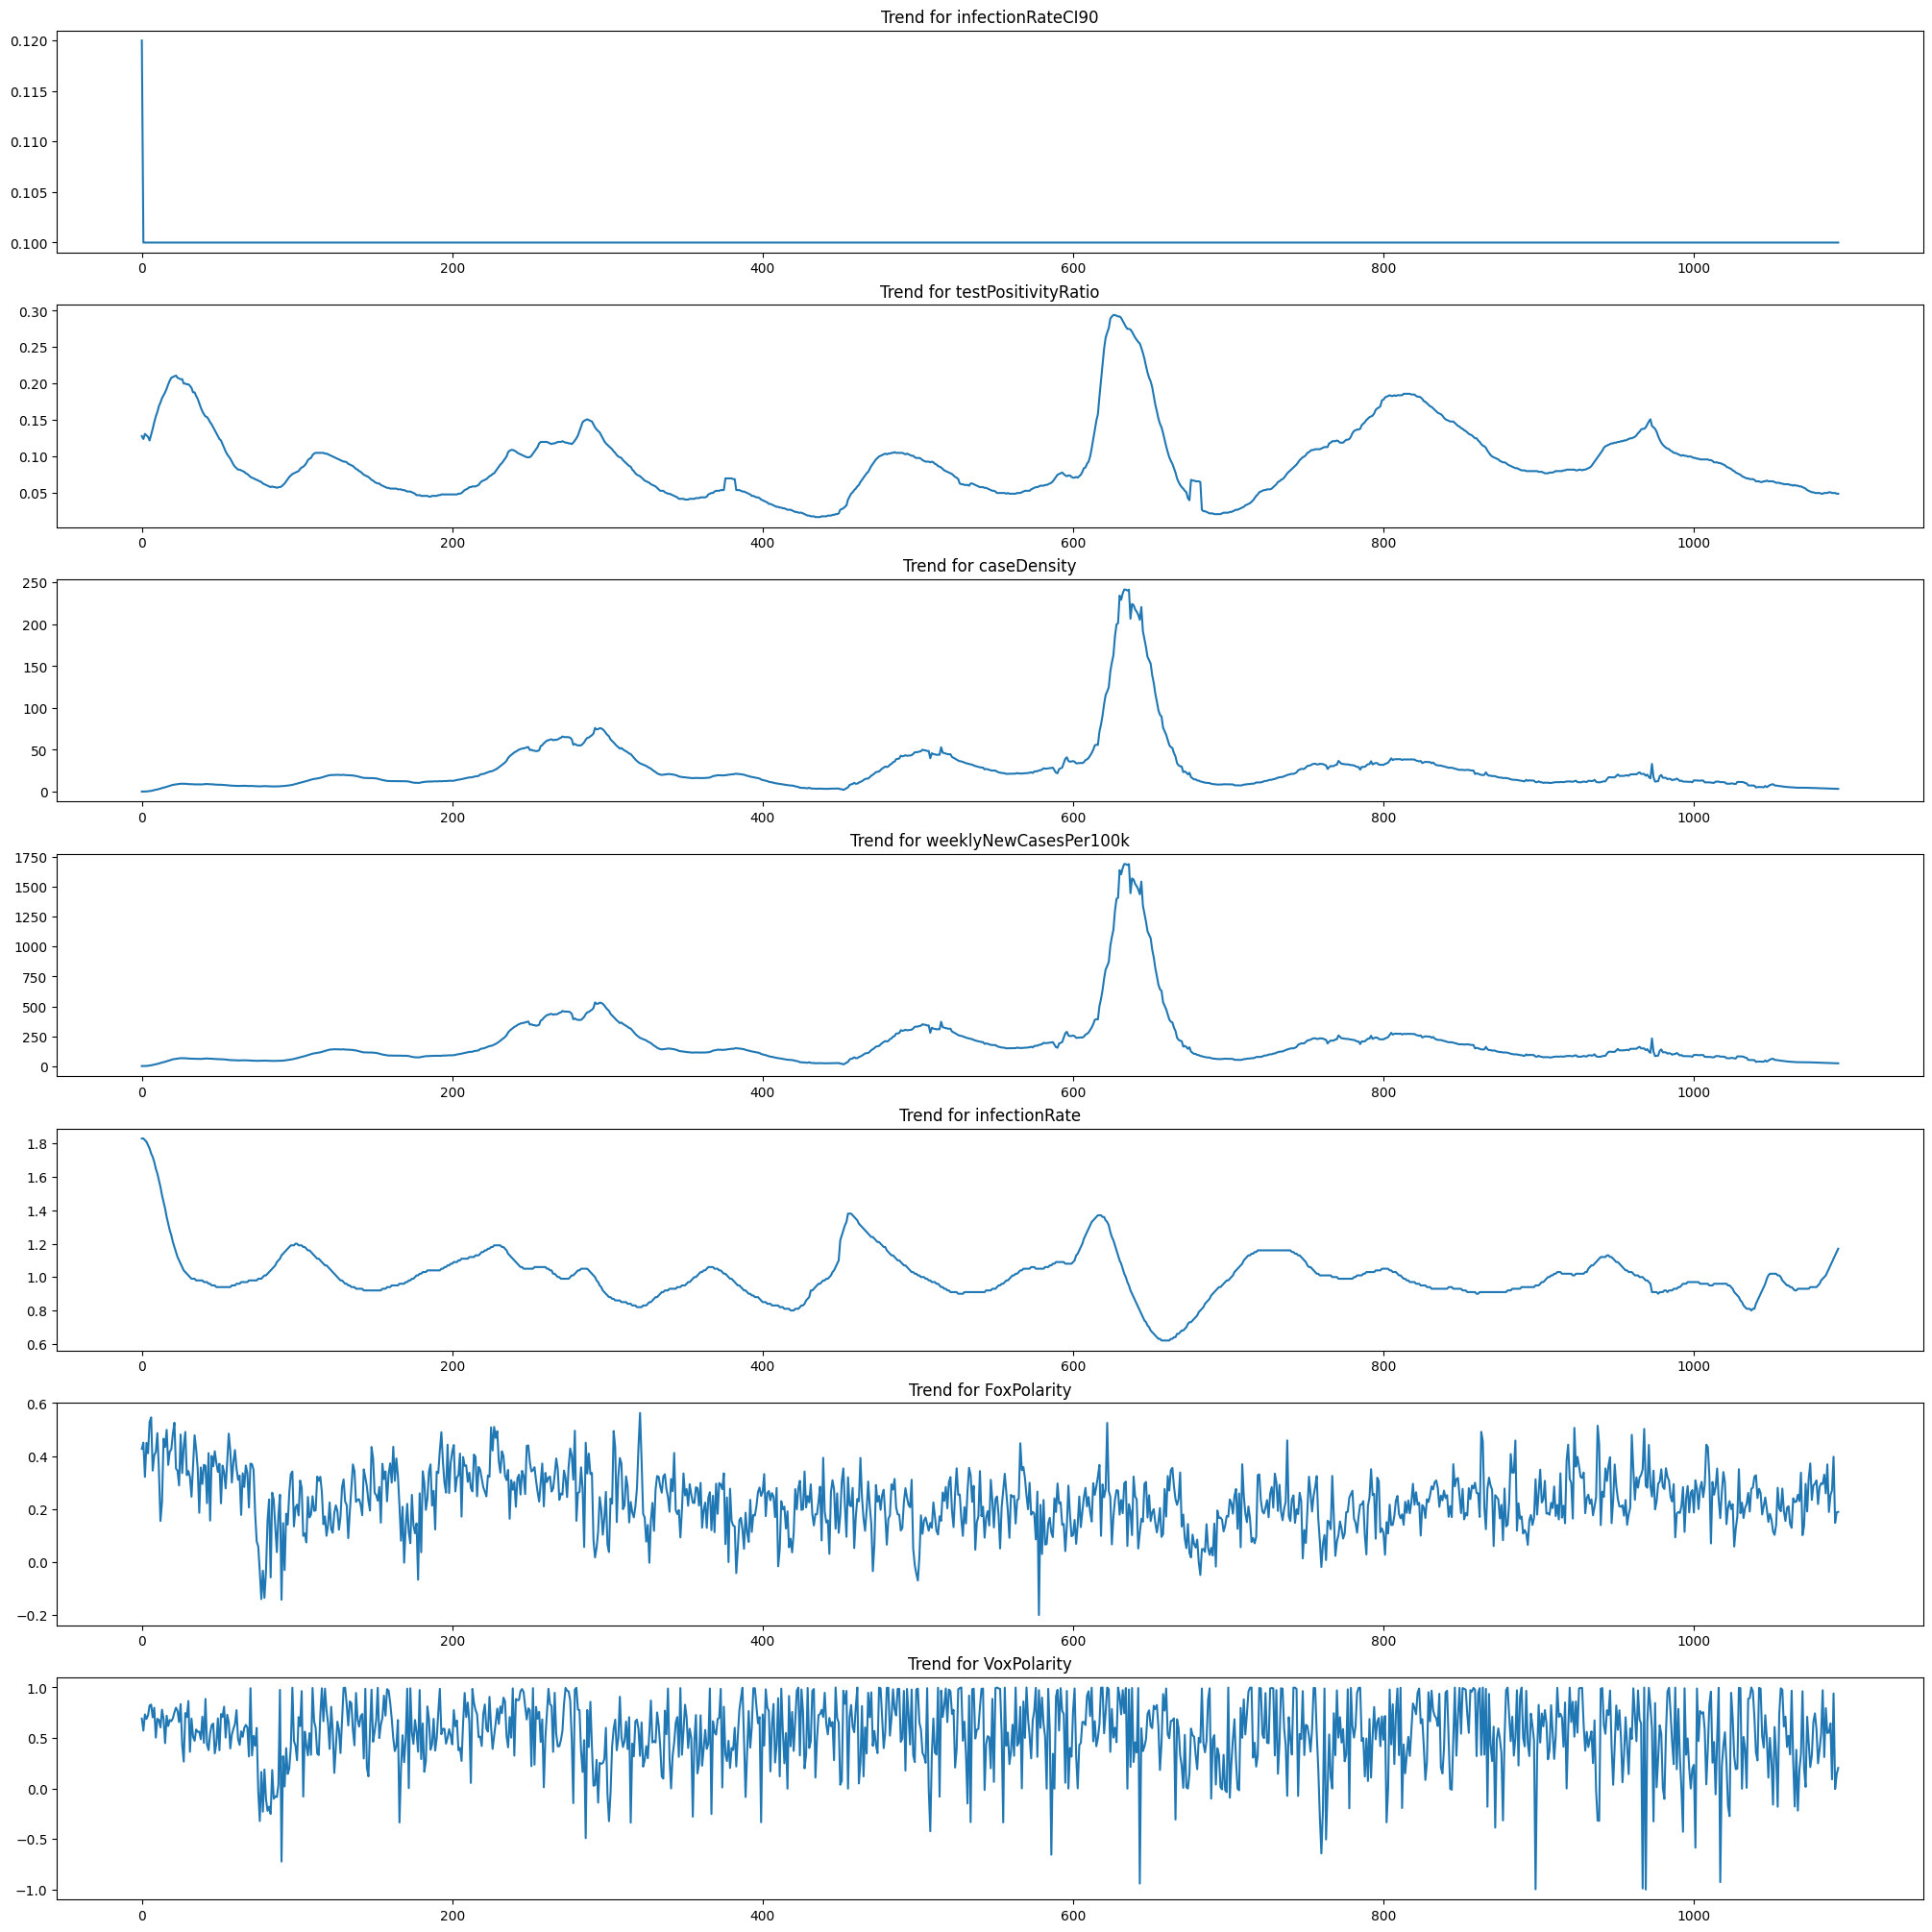

In [3]:
# Gather the list of our relevant predictors
predictors = complete_df.columns[2:]

# Plot their trends over time (i.e., index)
fig, ax = plt.subplots(len(predictors), figsize=(20, 20), constrained_layout=True)

for i in range(len(predictors)):
    currColumn = predictors[i]
    ax[i].plot(complete_df[currColumn].values)
    ax[i].set_title(f'Trend for {currColumn}')

plt.show()

Immediately, it seems that one of our predictors, infectionRateCI90, although has no missing values, it is not a very informative feature and may not have been properly recorded. We will drop this column.

In [4]:
complete_df = complete_df.drop(columns=['infectionRateCI90'])

Let's also see if there is any correlation between our predictors. 

In [5]:
complete_df.corr()

,date,fromStart,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,FoxPolarity,VoxPolarity
date,1.000000,1.000000,0.060563,0.011116,0.011096,-0.232238,-0.155511,-0.056557
fromStart,1.000000,1.000000,0.060563,0.011116,0.011096,-0.232238,-0.155511,-0.056557
testPositivityRatio,0.060563,0.060563,1.000000,0.665366,0.665391,0.131487,0.147766,0.064106
caseDensity,0.011116,0.011116,0.665366,1.000000,1.000000,-0.119325,-0.050340,0.049702
weeklyNewCasesPer100k,0.011096,0.011096,0.665391,1.000000,1.000000,-0.119291,-0.050360,0.049674
infectionRate,-0.232238,-0.232238,0.131487,-0.119325,-0.119291,1.000000,0.193536,0.088714
FoxPolarity,-0.155511,-0.155511,0.147766,-0.050340,-0.050360,0.193536,1.000000,0.145797
VoxPolarity,-0.056557,-0.056557,0.064106,0.049702,0.049674,0.088714,0.145797,1.000000


We seem to have a perfect positive correlation between caseDensity and weeklyNewCasesPer100k as well as date and Date Since Start. We will drop he weeklyNewCasesPer100k and date columns. 

In [6]:
complete_df = complete_df.drop(columns=['weeklyNewCasesPer100k', 'date'])

In [7]:
complete_df.corr()

,fromStart,testPositivityRatio,caseDensity,infectionRate,FoxPolarity,VoxPolarity
fromStart,1.000000,0.060563,0.011116,-0.232238,-0.155511,-0.056557
testPositivityRatio,0.060563,1.000000,0.665366,0.131487,0.147766,0.064106
caseDensity,0.011116,0.665366,1.000000,-0.119325,-0.050340,0.049702
infectionRate,-0.232238,0.131487,-0.119325,1.000000,0.193536,0.088714
FoxPolarity,-0.155511,0.147766,-0.050340,0.193536,1.000000,0.145797
VoxPolarity,-0.056557,0.064106,0.049702,0.088714,0.145797,1.000000


We additonally have some interaction between terms, especially betwen caseDensity and testPositivityRatio. We will consider these for interaction terms in our subsequent modeling section. For now, let's get a general understanding of the distribution of our data with a pair-plot. 

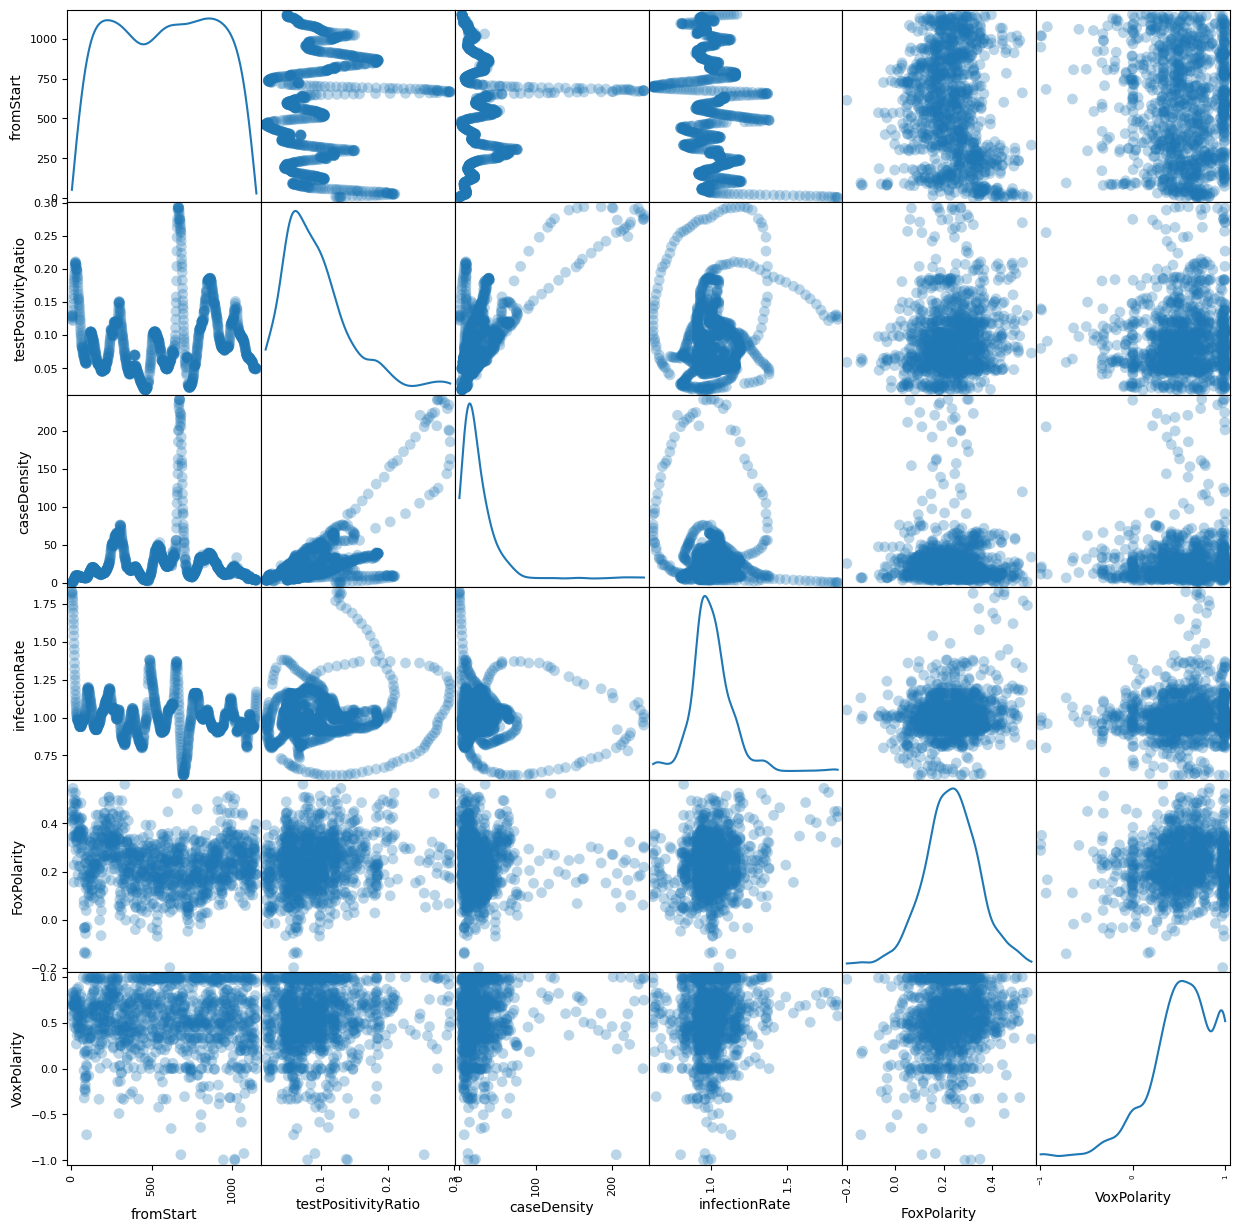

In [8]:
pair_plots = pd.plotting.scatter_matrix(complete_df, figsize=(15,15),marker='o', 
                                        hist_kwds={'bins': 20}, s=60, alpha=.3,diagonal='kde')

#for subaxis in pair_plots:
#    for ax in subaxis:
#        ax.xaxis.set_ticks([])
#        ax.yaxis.set_ticks([])
        
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.show()

Something we notice is the roughly normal distribution of each of the predictors, and the response variable, the Polarity Scores.

Observing the plots for caseDensity vstestPositivityRatio as well reveals the roughly linear nature between the two groups, and suggests the usage of an interaction term between the two. 

Let's also take a look at the scatter plots between the response and the predictors to see if we can gain any more good information. 

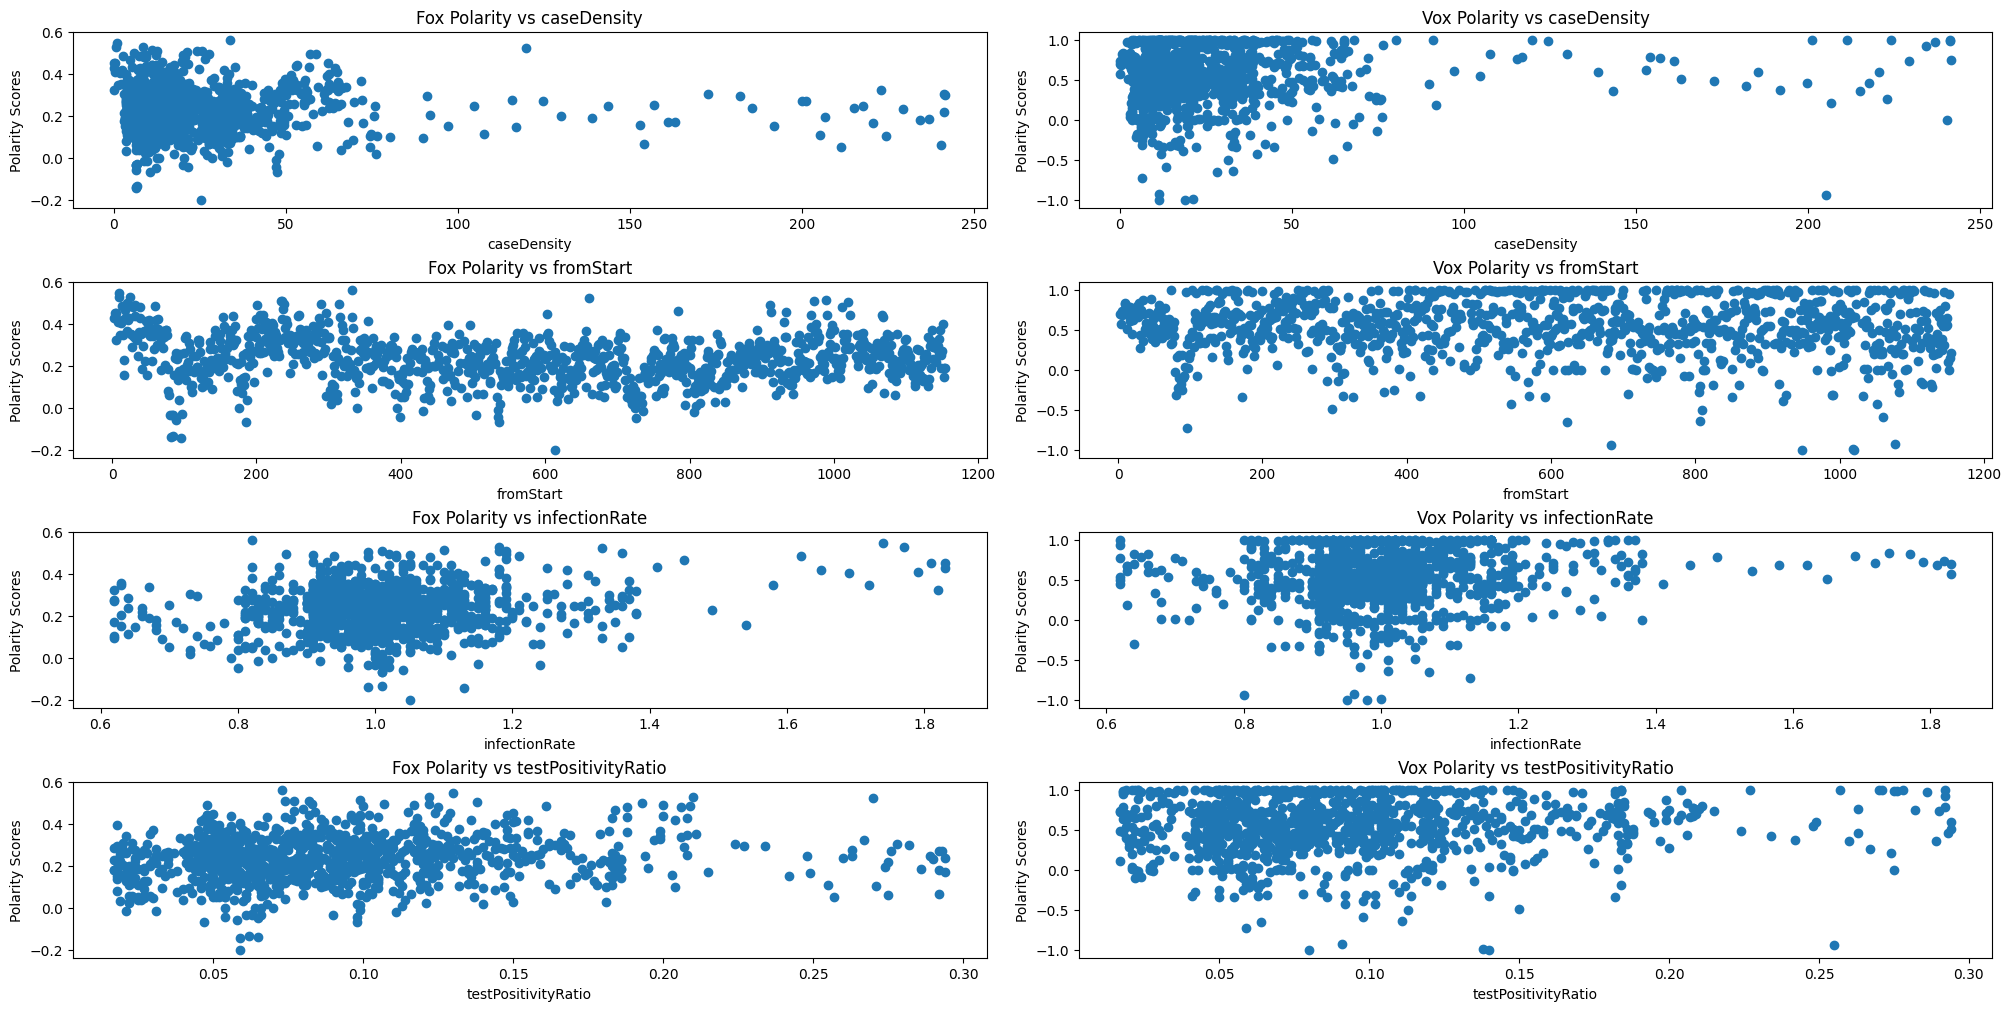

In [9]:
predictors  = complete_df.columns.difference(['VoxPolarity', 'FoxPolarity'])
foxResponse = complete_df['FoxPolarity']

# Graph the relationship of the predictors to each response
fig, ax = plt.subplots(4, 2, figsize=(20,10), constrained_layout=True)

# First graph for FoxPolarity
for i in range(len(predictors)):
    cur_col = complete_df[predictors[i]]
    
    ax[i][0].scatter(cur_col, foxResponse)
    
    ax[i][0].set(xlabel=predictors[i],ylabel='Polarity Scores')
    ax[i][0].set_title(f'Fox Polarity vs {predictors[i]}')

# Second graph for VoxPolarity
for i in range(len(predictors)):
    cur_col = complete_df[predictors[i]]
    
    ax[i][1].scatter(cur_col, complete_df['VoxPolarity'])
    
    ax[i][1].set(xlabel=predictors[i],ylabel='Polarity Scores')
    ax[i][1].set_title(f'Vox Polarity vs {predictors[i]}')

### Regression Preparation

Before we do any further processing of data, let's normalize the value of our predictors besides the time dependent values using a Z-Transform.

1. Normalize the value of our predictors besides the time dependent values.

we split our data into a train and testing set. We will achieve this through utilizing the Time Series Split package from SKLearn which separates our data into sequential paritions due to the constraint of time being one of our data points. Without this sequential split, our interpretations and model training would be illogical.

In [10]:
# Get the columns which need to be normalized
to_norm = complete_df.columns.difference(['FoxPolarity', 'VoxPolarity', 'fromStart'])

In [11]:
# Normalize the data using a Z-Transformation within a copied dataframe
norm_df = complete_df.copy()

z_transform = lambda x: (x - x.mean()) / x.std()

norm_df[to_norm] = norm_df[to_norm].apply(z_transform)

In [12]:
val_split     = 0.85
val_split_idx = int(len(complete_df) * 0.85)

training_data = complete_df.iloc[:val_split_idx]
testing_data  = complete_df.iloc[val_split_idx:]

We are now ready to perform a basic regression. Before doing any feature selection, we will first use all of our variables to get a good baseline approach.

Since we observed a roughly 0.66 correlation between case density and test positivity ratio, we will include an interaction term for those two within our formula.

In [13]:
# Get a list of our finalized predictors (complete list)
allPredict = complete_df.columns.difference(['FoxPolarity', 'VoxPolarity', 
                                             'caseDensity', 'testPositivityRatio']).to_list()

interactionTerm = 'caseDensity * testPositivityRatio'

allPredict.append(interactionTerm)

allPredict

['fromStart', 'infectionRate', 'caseDensity * testPositivityRatio']

As we perform our model training, we will also do some cross-validation to establish an evaluation of the model.

Our cross-validation will be through utilizing the Time Series Split package from SKLearn which separates our data into sequential paritions due to the constraint of time being one of our data points. Without this sequential split, our interpretations and model training would be illogical.

To make sure that the error metric we use is on the same scale of the polarity scores, since it is especially important here given their meaning, and the fact that they are between -1 and 1 we will use the RMSE. However, this (-1,1) range was changed a little bit as we dropped some rows, so we will also report the mean absolute percentage error (MAPE).

We can encapsulate this into a function so that we can see how various models perform by just passing in the model formula.

In [14]:
def trainModel(formula, data, response):
    '''
    Applies Cross-Validation for a given model and returns the average Root MSE and
    Mean Absolute Percentage Error (MAPE) for the model

    Parameters
    ----------
    formula : str
        The formula to be used for the model

    data : DataFrame
        The data to be used for the model
    
    Returns
    -------
    trainRMSE : float
        The average Root MSE for the training data
    
    testRMSE : float
        The average Root MSE for the testing data
    
    trainMAPE : float
        The average MAPE for the training data
    
    testMAPE : float
        The average MAPE for the testing data
    '''

    # Establish the Cross-Validation parameters
    splits = 10
    tscv = TimeSeriesSplit(n_splits=splits)

    trainRMSE = np.zeros(splits)
    testRMSE  = np.zeros(splits)
    trainMAPE = np.zeros(splits)
    testMAPE  = np.zeros(splits)

    # Iterate through the splits
    for i, (train_index, test_index) in enumerate(tscv.split(data)):

        # Split the data into training and testing sets
        train = data.iloc[train_index]
        test  = data.iloc[test_index]

        # Fit the model
        model = ols(formula=formula, data=train).fit()

        # Get the predictions for the training and testing sets
        train_pred = model.predict(train)
        test_pred  = model.predict(test)

        # Calculate the Root MSE and MAPE for the training and testing sets
        trainRMSE[i] = np.sqrt(mse(train[response], train_pred))
        testRMSE[i]  = np.sqrt(mse(test[response], test_pred))

        trainMAPE[i] = mean_absolute_percentage_error(train[response], train_pred)
        testMAPE[i]  = mean_absolute_percentage_error(test[response], test_pred)
    
    # Return the average Root MSE and MAPE for the training and testing sets
    return np.mean(trainRMSE), np.mean(testRMSE), np.mean(trainMAPE), np.mean(testMAPE)

### All Parameters -- Fox

In [15]:
foxForm = 'FoxPolarity ~ 1 + ' + ' + '.join(allPredict)

In [16]:
init_fox_trainRMSE, init_fox_testRMSE, init_fox_trainMAPE, init_fox_testMAPE = trainModel(foxForm, norm_df, 'FoxPolarity')

In [17]:
init_fox_trainRMSE, init_fox_testRMSE, init_fox_trainMAPE, init_fox_testMAPE

(0.1078362710064303, 0.23565830036466223, 2.098580238511071, 3.477847615592809)

### All Parameters -- Vox

In [18]:
voxForm = 'VoxPolarity ~ 1 + ' + ' + '.join(allPredict)

In [19]:
init_vox_trainRMSE, init_vox_testRMSE, init_vox_trainMAPE, init_vox_testMAPE = trainModel(voxForm, norm_df, 'VoxPolarity')

In [20]:
init_vox_trainRMSE, init_vox_testRMSE, init_vox_trainMAPE, init_vox_testMAPE

(0.297892002893252, 0.5269883674353772, 9.15672056235044, 19.954206560352898)

## Model Selection -- Fox

Now that we have some basic functionality, lets do some variable selection to get the best possible model. Since we only have five features, it realistic to perform best subset collection here. 

In [21]:
# Revise allPredict to label out each of the terms
allPredict = ['fromStart', 'infectionRate','caseDensity', 
              'testPositivityRatio', 'caseDensity:testPositivityRatio']

In [22]:
predict_combo = []
[predict_combo.extend(combinations(allPredict,i)) for i in range(len(allPredict)+1)]

[None, None, None, None, None, None]

In [23]:
foxErrorMetric = {
    'rmse': {},
    'mape': {}
}

In [24]:
# Compute the error metrics for each combination of predictors using the FoxPolarity response
# and our trainModel function
for i,combination in enumerate(predict_combo):
    currFoxForm = 'FoxPolarity ~ 1 + ' + ' + '.join(combination)

    if i == 0:
        currFoxForm = 'FoxPolarity ~ 1'

    _, foxTestRMSE, _, foxTestMAPE = trainModel(currFoxForm, norm_df, 'FoxPolarity')

    foxErrorMetric['rmse'][i] = foxTestRMSE
    foxErrorMetric['mape'][i] = foxTestMAPE

foxErrorMetric

{'rmse': {0: 0.10455768584161484,
  1: 0.13148255156384198,
  2: 0.10284597206249968,
  3: 0.11923211650674466,
  4: 0.10883739004371067,
  5: 0.16220104125359155,
  6: 0.13152979926881753,
  7: 0.13069519557801462,
  8: 0.12420510360000095,
  9: 0.16945413300839207,
  10: 0.12008611162895091,
  11: 0.10782003178979724,
  12: 0.15084500456809072,
  13: 0.11292941248641453,
  14: 0.17036885423119122,
  15: 0.15880200524729396,
  16: 0.12108696283192495,
  17: 0.12618036372136873,
  18: 0.16194070603881824,
  19: 0.15345515940286886,
  20: 0.19862002861709352,
  21: 0.1862138886244557,
  22: 0.10884090724882692,
  23: 0.15608050384264152,
  24: 0.16315874886434253,
  25: 0.1507637452478997,
  26: 0.16020880934527268,
  27: 0.19917376503202416,
  28: 0.19865011636546825,
  29: 0.20075630652510087,
  30: 0.1678879351033259,
  31: 0.23565830036466223},
 'mape': {0: 3.624276672374355,
  1: 2.5973659957308186,
  2: 3.1856285011707555,
  3: 3.6446173362239946,
  4: 3.3890504666457817,
  5: 3.6

In [29]:
min_mape_arg = predict_combo[np.argmin(list(foxErrorMetric['mape'].values()))]
min_rmse_arg = predict_combo[np.argmin(list(foxErrorMetric['rmse'].values()))]

print(f'The combination of predictors with the lowest MAPE is {*min_mape_arg,}')
print(f'The combination of predictors with the lowest RMSE is {*min_rmse_arg,}')

The combination of predictors with the lowest MAPE is ('fromStart', 'infectionRate', 'caseDensity')
The combination of predictors with the lowest RMSE is ('infectionRate',)


## Model Selection -- Vox

We'll perform the same thing now but with the Vox data.

In [30]:
voxErrorMetric = {
    'rmse': {},
    'mape': {}
}

In [31]:
# Compute the error metrics for each combination of predictors using the VoxPolarity response
# and our trainModel function
for i,combination in enumerate(predict_combo):
    currVoxForm = 'VoxPolarity ~ 1 + ' + ' + '.join(combination)

    if i == 0:
        currVoxForm = 'VoxPolarity ~ 1'

    _, voxTestRMSE, _, voxTestMAPE = trainModel(currVoxForm, norm_df, 'VoxPolarity')

    voxErrorMetric['rmse'][i] = voxTestRMSE
    voxErrorMetric['mape'][i] = voxTestMAPE

voxErrorMetric

{'rmse': {0: 0.3491365800278786,
  1: 0.393175947164306,
  2: 0.3499612895045277,
  3: 0.373130042162099,
  4: 0.35864273261400126,
  5: 0.4137612523790266,
  6: 0.3925653166253521,
  7: 0.42747922828428686,
  8: 0.40048011164570463,
  9: 0.46246728880733884,
  10: 0.4240802552468003,
  11: 0.35893495323872965,
  12: 0.4045840578782681,
  13: 0.410893343269947,
  14: 0.4549745908876675,
  15: 0.4787930870669047,
  16: 0.43596679324936993,
  17: 0.3983242204528932,
  18: 0.44865136018190876,
  19: 0.4483498257814234,
  20: 0.5025901813379854,
  21: 0.46235132992046646,
  22: 0.4197923785678756,
  23: 0.4549029500293038,
  24: 0.49971438228031406,
  25: 0.4657230127901544,
  26: 0.5088716986595279,
  27: 0.546530640461578,
  28: 0.45712653248601587,
  29: 0.4785399186168249,
  30: 0.46547280028674215,
  31: 0.5269883674353772},
 'mape': {0: 17.733314879816103,
  1: 18.312098453491235,
  2: 17.300829570020973,
  3: 17.828743675542277,
  4: 17.41462869577448,
  5: 18.268005884362157,
  6: 

In [32]:
vox_mape_arg = predict_combo[np.argmin(list(voxErrorMetric['mape'].values()))]
vox_rmse_arg = predict_combo[np.argmin(list(voxErrorMetric['rmse'].values()))]

print(f'The combination of predictors with the lowest MAPE is {*vox_mape_arg,}')
print(f'The combination of predictors with the lowest RMSE is {*vox_rmse_arg,}')

The combination of predictors with the lowest MAPE is ('infectionRate', 'testPositivityRatio')
The combination of predictors with the lowest RMSE is ()


## Running the Best Fox Model
---
Now that we've ran our model selection, let's compute our error metrics for our best model.

In [36]:
foxBestForm = 'FoxPolarity ~ 1 + ' + ' + '.join(min_mape_arg)

foxBest = ols(formula=foxBestForm, data=norm_df).fit()

foxBest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            FoxPolarity   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     19.62
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           2.15e-12
Time:                        18:03:20   Log-Likelihood:                 903.15
No. Observations:                1094   AIC:                            -1798.
Df Residuals:                    1090   BIC:                            -1778.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2556      0.007     39.084      0.000       0.243       0.268
fromStart     -3.815e-05   9.86e-06     -3.869      0.000   -5.75e-05   -1.88e-05
infectionRate     0.0177      0.003      5.326      0.000       0.011       0.024
caseDensity      -0.0032      0.003     -0.997      0.319      -0.010       0.003
==============================================================================
Omnibus:                       22.543   Durbin-Watson:                   1.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.218
Skew:                          -0.244   Prob(JB):                     4.52e-07
Kurtosis:                       3.635   Cond. No.                     1.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

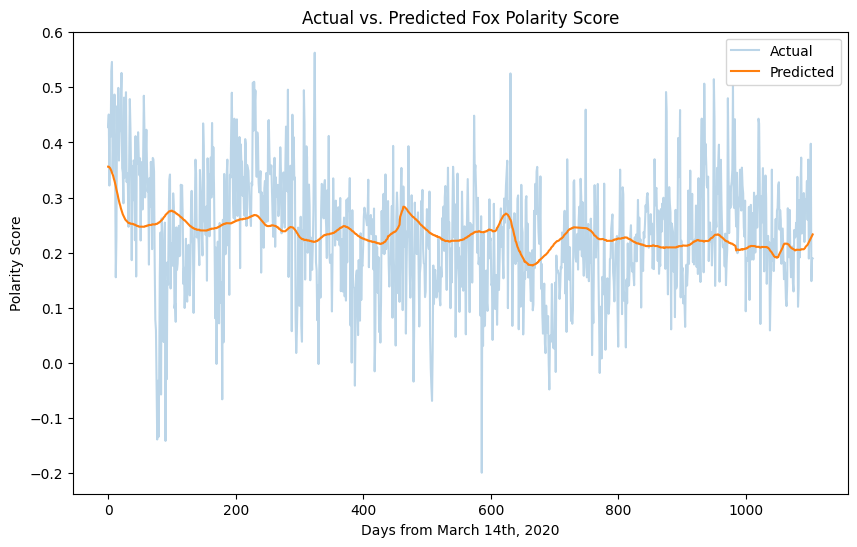

In [43]:
# Get the predictions for the FoxPolarity response
foxBestPred = foxBest.predict(norm_df)

# Plot the actual FoxPolarity response against the predicted FoxPolarity response
plt.figure(figsize=(10,6))
plt.plot(norm_df['FoxPolarity'], label='Actual', alpha=0.3)
plt.plot(foxBestPred, label='Predicted')
plt.title('Actual vs. Predicted Fox Polarity Score')
plt.legend()
plt.xlabel('Days from March 14th, 2020')
plt.ylabel('Polarity Score')
plt.show()

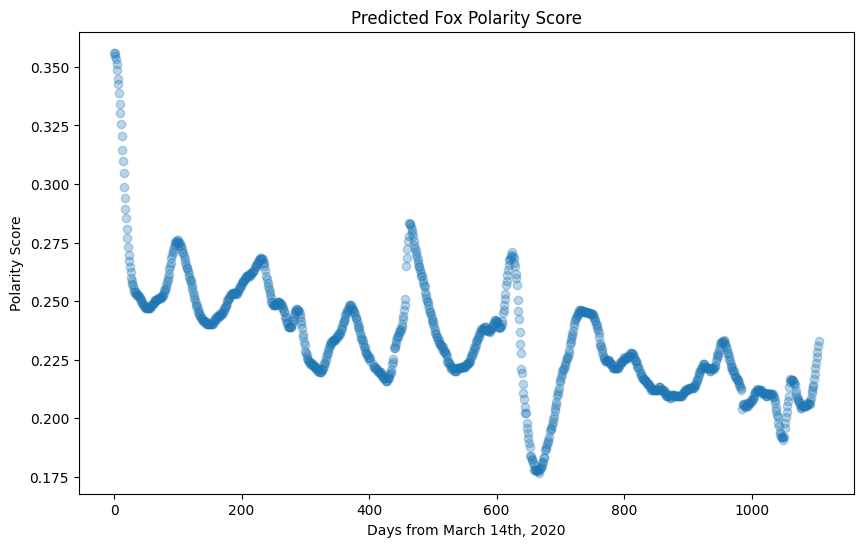

In [45]:
# Get a scatterplot of the general trend of the predicted FoxPolarity response
plt.figure(figsize=(10,6))
plt.scatter(x=norm_df.index, y=foxBestPred, alpha=0.3)
plt.title('Predicted Fox Polarity Score')
plt.xlabel('Days from March 14th, 2020')
plt.ylabel('Polarity Score')
plt.show()

Text(0, 0.5, 'Predicted Fox Polarity Score')

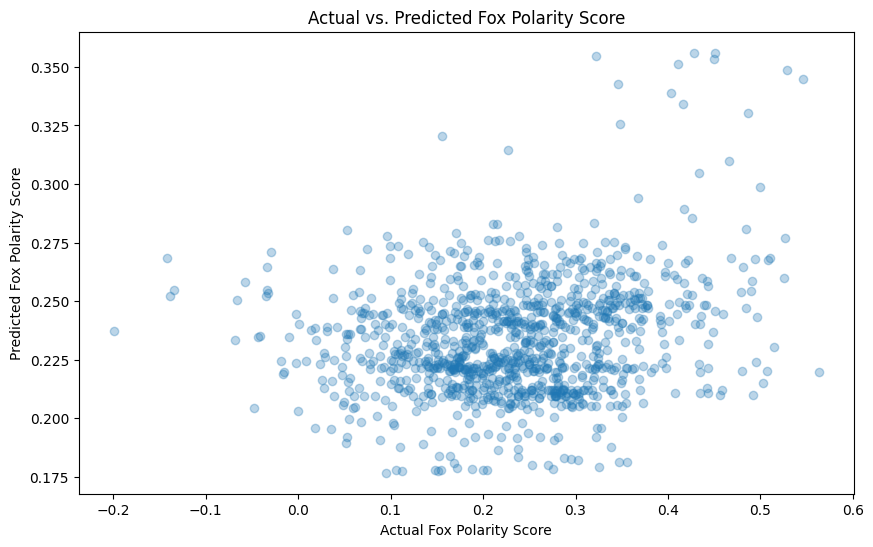

In [51]:
# Generate a scatterplot of the predicted FoxPolarity response against the actual response
plt.figure(figsize=(10,6))
plt.scatter(x=norm_df['FoxPolarity'], y=foxBestPred, alpha=0.3)
plt.title('Actual vs. Predicted Fox Polarity Score')
plt.xlabel('Actual Fox Polarity Score')
plt.ylabel('Predicted Fox Polarity Score')

In [52]:
# Generate a matrix of the correlation between actual and predicted FoxPolarity response
pd.DataFrame(np.corrcoef(norm_df['FoxPolarity'],foxBestPred))

,0,1
0,1.000000,0.226367
1,0.226367,1.000000


In [58]:
# Calculate the Root MSE and MAPE for the FoxPolarity response
foxBestRMSE = np.sqrt(mse(norm_df['FoxPolarity'],foxBestPred))
foxBestMAPE = mean_absolute_percentage_error(norm_df['FoxPolarity'],foxBestPred)

print(f'The Root MSE for the FoxPolarity response is {foxBestRMSE}')
print(f'The MAPE for the FoxPolarity response is {foxBestMAPE}')

The Root MSE for the FoxPolarity response is 0.10598141598606768
The MAPE for the FoxPolarity response is 2.8520572408440183


# Running the Best Vox Model
---
Let's do the same for the best Vox Model.

In [53]:
voxBestForm = 'VoxPolarity ~ 1 + ' + ' + '.join(vox_mape_arg)

voxBest = ols(formula=voxBestForm, data=norm_df).fit()

voxBest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            VoxPolarity   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.883
Date:                Wed, 14 Jun 2023   Prob (F-statistic):            0.00288
Time:                        18:10:53   Log-Likelihood:                -390.48
No. Observations:                1094   AIC:                             787.0
Df Residuals:                    1091   BIC:                             802.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5428      0.010     51.852      0.000       0.522       0.563
infectionRate           0.0284      0.011      2.689      0.007       0.008       0.049
testPositivityRatio     0.0186      0.011      1.757      0.079      -0.002       0.039
==============================================================================
Omnibus:                      150.536   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.862
Skew:                          -0.911   Prob(JB):                     1.11e-53
Kurtosis:                       4.425   Cond. No.                         1.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

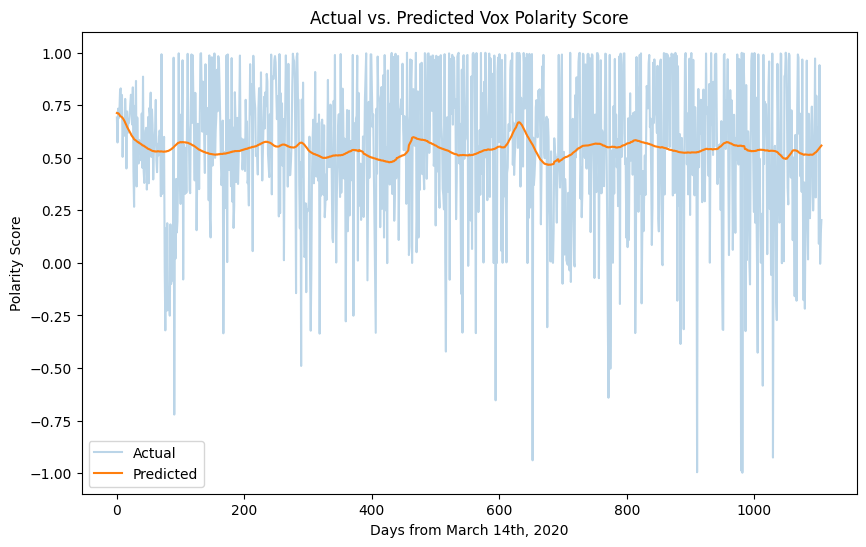

In [54]:
# Get the predictions for the VoxPolarity response
voxBestPred = voxBest.predict(norm_df)

# Plot the actual VoxPolarity response against the predicted VoxPolarity response
plt.figure(figsize=(10,6))
plt.plot(norm_df['VoxPolarity'], label='Actual', alpha=0.3)
plt.plot(voxBestPred, label='Predicted')
plt.title('Actual vs. Predicted Vox Polarity Score')
plt.legend()
plt.xlabel('Days from March 14th, 2020')
plt.ylabel('Polarity Score')
plt.show()

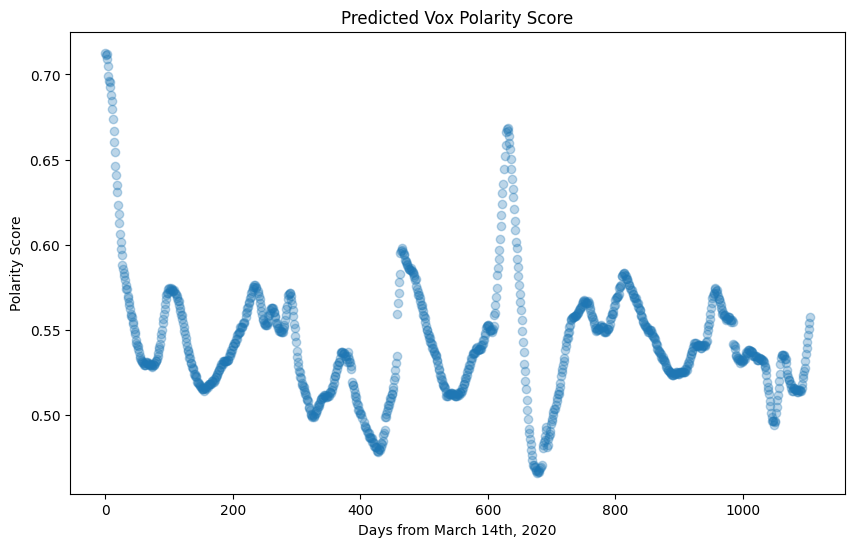

In [55]:
# Get a scatterplot of the general trend of the predicted VoxPolarity response
plt.figure(figsize=(10,6))
plt.scatter(x=norm_df.index, y=voxBestPred, alpha=0.3)
plt.title('Predicted Vox Polarity Score')
plt.xlabel('Days from March 14th, 2020')
plt.ylabel('Polarity Score')
plt.show()

Text(0, 0.5, 'Predicted Vox Polarity Score')

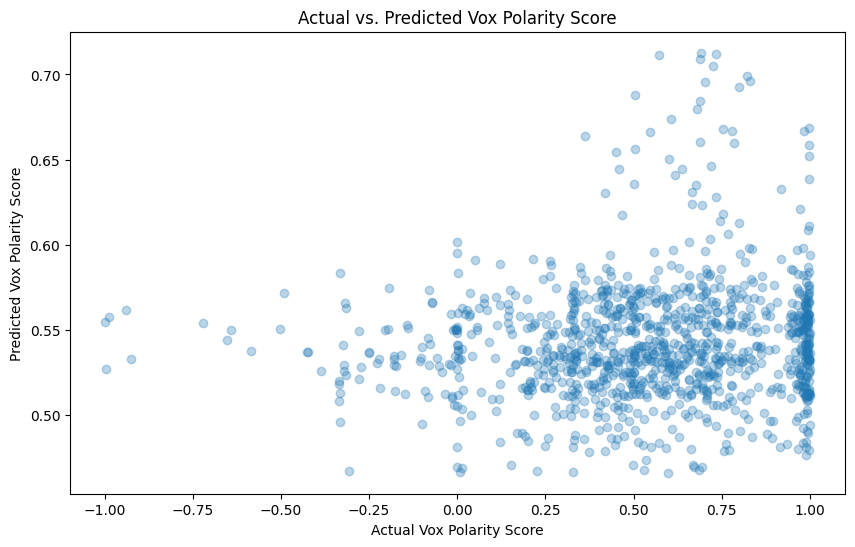

In [56]:
# Generate a scatterplot of the predicted VoxPolarity response against the actual response
plt.figure(figsize=(10,6))
plt.scatter(x=norm_df['VoxPolarity'], y=voxBestPred, alpha=0.3)
plt.title('Actual vs. Predicted Vox Polarity Score')
plt.xlabel('Actual Vox Polarity Score')
plt.ylabel('Predicted Vox Polarity Score')

In [57]:
# Generate a matrix of the correlation between actual and predicted VoxPolarity response
pd.DataFrame(np.corrcoef(norm_df['VoxPolarity'],voxBestPred))

,0,1
0,1.000000,0.103289
1,0.103289,1.000000


In [59]:
# Calculate the Root MSE and MAPE for the VoxPolarity response
voxBestRMSE = np.sqrt(mse(norm_df['VoxPolarity'],voxBestPred))
voxBestMAPE = mean_absolute_percentage_error(norm_df['VoxPolarity'],voxBestPred)

print(f'The Root MSE for the VoxPolarity response is {voxBestRMSE}')
print(f'The MAPE for the VoxPolarity response is {voxBestMAPE}')

The Root MSE for the VoxPolarity response is 0.34576172922784093
The MAPE for the VoxPolarity response is 15.19717302025569
